In [6]:
#Move up a directory
import os
print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/Users/riley/Desktop/RAFTS/Notebooks
/Users/riley/Desktop/RAFTS


In [10]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from astropy.io import fits

from utils import filt_interp, make_bb, dcr_offset, makeGaussian
from config import WAVELENGTH
import globals

globals.initialize()


17.391835997139935 17.27719891560202


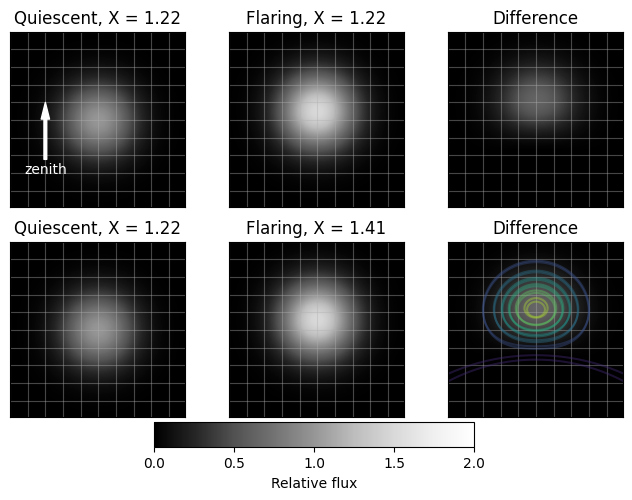

In [11]:
### Make quiescent and flaring PSFs for an input temp, airmass, etc

#set constants
size = 200
pixscale = 0.01 #arcsec/pixel
fwhm = 0.7 / pixscale #0.7" seeing 
temp = 10000
am_i = 1 / np.cos(np.deg2rad(35))
am_f = 1 / np.cos(np.deg2rad(45))
band= 'g'
flux_factor = 1.5
f = filt_interp(band)


#import spectra
iSED = np.load('mdspec_full.npy')
fSED = np.load('mdspec_full.npy') + make_bb(WAVELENGTH, temp) * globals.BBnorm
flatSED = np.full_like(iSED, 0.1)


hdul = fits.open('ukg5v.fits')
g5vwavelength = np.arange(1150,25005, 5)
g5vSED_old = hdul[0].data

g5vf = interp1d(g5vwavelength, g5vSED_old, fill_value='extrapolate')
g5vSED = g5vf(WAVELENGTH)


#DCR First moment
def Rbar(SED, am):
    p = SED[f(WAVELENGTH) > 0] * f(WAVELENGTH)[f(WAVELENGTH) > 0]
    weff = np.exp(np.sum(p * np.log(WAVELENGTH[f(WAVELENGTH) > 0])) / np.sum(p))
    R = dcr_offset(weff, airmass = am) 
    
    return np.sum(p * R) / np.sum(p), weff

Rbar_i, weff_i = Rbar(iSED, am_i)
Rbar_f, weff_f = Rbar(fSED, am_i)
dRbar = Rbar_f - Rbar_i

#DCR Second moment
def V(SED, am):
    p = SED[f(WAVELENGTH) > 0] * f(WAVELENGTH)[f(WAVELENGTH) > 0]
    R = dcr_offset(WAVELENGTH[f(WAVELENGTH) > 0], airmass=am)
    Rbar = np.sum(p * R) / np.sum(p)

    return np.sum(p * (R-Rbar)**2) / np.sum(p)

V_i = V(iSED, am_i)
V_f = V(fSED, am_i)
dV = V_f - V_i

#Make Gaussians
psf_i = makeGaussian(size, fwhm_x = fwhm, fwhm_y = fwhm)
psf_f = makeGaussian(size, fwhm_x = fwhm * (weff_f/weff_i)**(-2/5), fwhm_y = fwhm * (weff_f/weff_i)**(-2/5) + dV, center=((size/2),(size/2 - (dRbar / pixscale)))) * flux_factor

#Plotting
fig, ax = plt.subplots(2,3, figsize=(8,5))
vrange = (0,2)
a = ax[0,0].imshow(psf_i, vmin = vrange[0], vmax = vrange[1], cmap='Greys_r')
b = ax[0,1].imshow(psf_f,  vmin = vrange[0], vmax = vrange[1], cmap='Greys_r')
c = ax[0,2].imshow(psf_f - psf_i, vmin = vrange[0], vmax = vrange[1], cmap='Greys_r')
cc = ax[1,2].contour(psf_f - psf_i, alpha = 0.4)

temp2 = psf_f - psf_i

x = WAVELENGTH[f(WAVELENGTH) > 0.0]
yg = f(WAVELENGTH)[f(WAVELENGTH) > 0.0]
yi = yg * iSED[f(WAVELENGTH) > 0.0]
yf = yg * fSED[f(WAVELENGTH) > 0.0]


ax[0,0].set_title('Quiescent, X = {0:.2f}'.format(am_i))
ax[0,1].set_title('Flaring, X = {0:.2f}'.format(am_i))
ax[0,2].set_title('Difference')


cbar_ax = fig.add_axes([0.31, 0.05, 0.4, 0.05])
fig.colorbar(a, cax=cbar_ax, label='Relative flux', orientation='horizontal')

ax[0,0].annotate('zenith', xy = (size * 1/5, size * 2/5), xytext=(size * 1/5, size * 4/5), horizontalalignment='center', color='white',
    arrowprops = dict(facecolor='white', color='white', width=2, headwidth=6))



########ROW 2

size2 = 200

Rbar_exp_i, weff_i = Rbar(g5vSED, am_i)
Rbar_exp_f, weff_f = Rbar(g5vSED, am_f)
dRbar_exp = Rbar_exp_f - Rbar_exp_i

Rbar_i, weff_i = Rbar(iSED, am_i)
Rbar_f, weff_f = Rbar(fSED, am_f)
dRbar = Rbar_f - Rbar_i

print(dRbar, dRbar_exp)

V_i = V(iSED, am_i)
V_f = V(fSED, am_f)
dV = V_f - V_i

#Make Gaussians
psf_i = makeGaussian(size2, fwhm_x = fwhm, fwhm_y = fwhm)
psf_f = makeGaussian(size2, fwhm_x = fwhm * (weff_f/weff_i)**(-2/5), fwhm_y = fwhm * (weff_f/weff_i)**(-2/5) + dV, center=((size2/2),(size2/2 - ((dRbar-dRbar_exp) / pixscale)))) * flux_factor


#Plotting
vrange = (0,2)
a = ax[1,0].imshow(psf_i, vmin = vrange[0], vmax = vrange[1], cmap='Greys_r')
b = ax[1,1].imshow(psf_f,  vmin = vrange[0], vmax = vrange[1], cmap='Greys_r')
c = ax[1,2].imshow(psf_f - psf_i, vmin = vrange[0], vmax = vrange[1], cmap='Greys_r')
cc2 = ax[1,2].contour(psf_f - psf_i, alpha = 0.4)

temp1 = psf_f - psf_i

ax[1,0].set_title('Quiescent, X = {0:.2f}'.format(am_i))
ax[1,1].set_title('Flaring, X = {0:.2f}'.format(am_f))
ax[1,2].set_title('Difference')

#Grid
for axis in ax.flatten():
    axis.set_xticks(np.arange(0,size,20))
    axis.set_yticks(np.arange(0,size,20))
    axis.set_xlim(0,size-2)
    axis.set_ylim(size-2,0)
    for tick in axis.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    for tick in axis.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    axis.grid(True, alpha=0.4)

    
###############

fig.savefig('Figures/psfshift3.png', dpi=300, bbox_inches='tight')